In [39]:
import pandas as pd
import os
import importlib
import functools
import time
from multiprocessing import Pool

import cftime
import nc_time_axis
import xarray as xr
import numpy as np
import matplotlib, matplotlib.pyplot as plt, matplotlib.patheffects as pe

import derived
import visualization
import utilities

importlib.reload(derived);
importlib.reload(utilities);
importlib.reload(visualization);

### Compositing methodology
1. Define TC characteristics
   - model name,
   - experiment name, 
   - year range
   - intensity range (optional)
   - basin name (optional)
2. Use TC characteristics to find corresponding saved TCs in defined directory
3. Define reference point (`reference_timestamp`) for sampling methodology for each TC
   - e.g., relative to LMI, relative to genesis)
4. Define time delta from reference point (i.e., `reference_timestamp + N hours`, `N` is integer)
5. For each TC identified:
   - a. Lazy load TC
   - b. Select at hour `reference_timestamp + N hours`
   - c. Drop all nan values
   - d. Store the selected data

In [2]:
def get_filename_year(filename: str) -> int:
    delimiter_string = 'storm_ID'
    filename_year = int(filename.split(f'{delimiter_string}-')[-1].split('-')[0])
    return filename_year

In [3]:
def get_filename_intensity(filename: str,
                           delimiter_string: str) -> int:
    filename_intensity = int(filename.split(f'{delimiter_string}-')[-1].split('.')[0])
    return filename_intensity

In [4]:
def get_sampling_timestamp(storm: xr.Dataset,
                           reference_point: str='LMI',
                           number_of_offset_hours: int=0,
                           intensity_parameter: str='max_wind') -> cftime._cftime.DatetimeNoLeap:

    ''' Method to obtain the timestamp to sample a TC at. '''
    
    # Get calendar format. Assumes calendar types are equivalent for all timestamps.
    timestamp_calendar_format = utilities.cftime_calendar_type(storm.time.values[0])
    # Obtain the first timestamp for a TC (assumed to be genesis)
    genesis_timestamp = storm.isel(time=0)['time'].item()
    # Define the identifier used as a reference time for cftime timedelta calculation
    reference_identifier = f'seconds since {genesis_timestamp}'

    # Obtain the reference timestamp (either genesis or LMI)
    if reference_point == 'LMI':
        # Obtain the value of maximum intensity
        maximum_intensity = storm[intensity_parameter].max() if intensity_parameter == 'max_wind' else storm[intensity_parameter].min()
        # Obtain the reference timestamp based on the maximum intensity value
        reference_timestamp = storm.where(storm[intensity_parameter] == maximum_intensity)[intensity_parameter].dropna(dim='time')['time']
        # Ensure that there's at least one valid timestamp, and remove any duplicate values
        assert len(reference_timestamp) > 0, f"No reference timestamp found for storm ID {storm.attrs['storm_id']}."
        reference_timestamp = reference_timestamp.item() if len(reference_timestamp) == 1 else reference_timestamp.isel(time=0).item()
    elif reference_point == 'genesis':
        reference_timestamp = genesis_timestamp
        assert number_of_offset_hours >= 0, f'Number of offset hours must be at least 0 when sampling a timestamp relative to storm genesis.'

    # Convert the cftime object to number of seconds since the reference time `reference_identifier`
    reference_timestamp_seconds = cftime.date2num(reference_timestamp, reference_identifier, calendar=timestamp_calendar_format)
    # Add the number of offset hours (in units of seconds)
    sampling_timestamp_seconds = reference_timestamp_seconds + number_of_offset_hours*3600
    # Convert this number back to a cftime object
    sampling_timestamp = cftime.num2date(sampling_timestamp_seconds, reference_identifier, calendar=timestamp_calendar_format)
    
    return sampling_timestamp

In [5]:
def get_sampling_time_window(storm: xr.Dataset,
                             sampling_timestamp: cftime.datetime,
                             sample_window_time_size: int=0,
                             diagnostic: bool=False) -> range:

    ''' Given a timestamp, return a range of indices around the timestamp for increased sampling in time around a given point in time. '''
    
    # Obtain index of sampling timestamp in the storm Dataset
    # Notice the indexing - this accesses the tuple generated by np.where
    sampling_timestamp_index = np.where(storm['time'].values == sampling_timestamp)[0]
    assert len(sampling_timestamp_index) == 1, f'Sampling timestamp {sampling_timestamp} has duplicate indices, but it should only have one.'
    
    # Generate the sampling timestamp window. A +1 is added for the Python range object
    sampling_window_minimum = sampling_timestamp_index[0] - sample_window_time_size
    sampling_window_maximum = sampling_timestamp_index[0] + sample_window_time_size + 1
    
    # Trim sampling window based on storm time axis size
    sampling_window_minimum = 0 if sampling_window_minimum < 0 else sampling_window_minimum
    sampling_window_maximum = len(storm.time.values) if sampling_window_maximum > len(storm.time.values) else sampling_window_maximum

    # Define sampling window range
    sampling_window = range(sampling_window_minimum, sampling_window_maximum)

    # Make sure window extent is within the bounds of the TC time axis
    assert (min(sampling_window) >= 0) & (max(sampling_window) < len(storm.time.values)), f'Time-index sampling window exceeds time axis size.'

    if diagnostic:
        print(f'Sampling timestamp index = {sampling_timestamp_index[0]}, with window = {sample_window_time_size}.')
    
    return sampling_window

In [6]:
def storm_interpolation_grid_basis_vectors(storm: xr.Dataset,
                                           window_size: int,
                                           equal_number_of_points: bool=True,
                                           diagnostic: bool=False) -> tuple[np.array, np.array]:

    ''' 
    Method to generate uniform interpolation basis vectors for a TC-centered grid. 
    Boolean `equal_number_of_points` is used to ensure equal grid point numbers, and is optional.
    '''

    # Ensure necessary basis vector dimensions are available
    assert ('grid_xt' in storm.dims) and ('grid_yt' in storm.dims)
    # Get differences in grid spacing along each vector
    d_grid_yt = storm['grid_yt'].diff(dim='grid_yt')
    d_grid_xt = storm['grid_xt'].diff(dim='grid_xt')

    # Ensure that the differences are equivalent for all indices to ensure equal spacing
    grid_tolerance = 1e-6
    assert sum(d_grid_xt.diff(dim='grid_xt') < grid_tolerance) == len(d_grid_xt) - 1, 'Grid is irregular along the `grid_xt` axis.'
    assert sum(d_grid_yt.diff(dim='grid_yt') < grid_tolerance) == len(d_grid_yt) - 1, 'Grid is irregular along the `grid_yt` axis.'
    # Get grid spacing along each direction
    dx, dy = d_grid_xt.isel(grid_xt=0).item(), d_grid_yt.isel(grid_yt=0).item()
    # Get the number of grid points in each direction for vector construction
    # Use the number of y-grid points if an equal number of points is desired in each direction, since y-resolution is typically smaller
    number_y_grid_points = int(np.around((window_size * 2) / dy))
    number_x_grid_points = number_y_grid_points if equal_number_of_points else int(np.around((window_size * 2) / dx))
    # Construct the basis vectors for Dataset interpolation
    arr_x_interp = np.linspace(-window_size, window_size, number_x_grid_points)
    arr_y_interp = np.linspace(-window_size, window_size, number_y_grid_points)

    if diagnostic:
        print(f'[storm_interpolation_gridpoints]: Number of grid points: x = {number_x_grid_points}, y = {number_y_grid_points}')

    return arr_x_interp, arr_y_interp

In [7]:
def storm_centered_interpolation(storm_sample: xr.Dataset,
                                 sampling_field: str,
                                 window_size: int=10) -> xr.DataArray:

    # Generate storm-centered coordinates.
    # This will remove dependence on global coordinates and allow for storm-centered compositing.
    arr_x = storm_sample.grid_xt - storm_sample['center_lon']
    arr_y = storm_sample.grid_yt - storm_sample['center_lat']

    # Generate storm ID list to serve as an axis for the storm identifier that will enable xArray-based compositing
    storm_ID = [storm_sample.attrs['storm_id']]
    # Expand dimensions of 2D data for the storm ID axis
    storm_sample_dataset = np.expand_dims(storm_sample[sampling_field].data, axis=0)
    # Generate the xArray DataArray
    sample = xr.DataArray(data=storm_sample_dataset,
                          dims=['storm_id', 'grid_yt_TC', 'grid_xt_TC'],
                          coords={'grid_xt_TC': (['grid_xt_TC'], arr_x.data),
                                  'grid_yt_TC': (['grid_yt_TC'], arr_y.data),
                                  'storm_id': (['storm_id'], storm_ID)})

    # To allow for the combination of different TCs, interpolate the storm-centered coordinates to common axis values based on the window size.
    arr_x_interp, arr_y_interp = storm_interpolation_grid_basis_vectors(storm_sample, window_size)

    # Perform an interpolation from the storm-centered coordinates to the interpolated coordinates
    interpolated_sample = sample.interp(grid_xt_TC=arr_x_interp).interp(grid_yt_TC=arr_y_interp)

    return interpolated_sample

In [8]:
def derived_quantities(model_name: str,
                       dataset: xr.Dataset):

    # Correct sign convention from positive down to positive up for upwards-directed quantities
    dataset['lwup_sfc'] = dataset['lwup_sfc'] * -1 if model_name in ['ERA5'] else dataset['lwup_sfc']
    dataset['swup_sfc'] = dataset['swup_sfc'] * -1 if model_name in ['ERA5'] else dataset['swup_sfc']

    # Correct for units from kg/m^2/s to mm/d
    for field_name in dataset.data_vars:
        factor = 86400 if field_name in ['precip', 'evap', 'p-e'] else 1
        dataset[field_name] = dataset[field_name] * factor

    # Generate derived fields
    dataset = derived.TC_surface_wind_speed(dataset)
    dataset = derived.net_lw(dataset)
    dataset = derived.net_sw(dataset)
    dataset = derived.atmospheric_heating(dataset)

    return dataset

In [9]:
def composite_sample_statistics(pathnames: list,
                                model_name: str,
                                experiment_name: str,
                                plot_histograms: bool=False):

    ''' Generate statistics about the storms used for a given composite analysis. '''

    assert isinstance(pathnames, list), 'Pathnames provided must be in a list object.'

    intensity_parameters = ['max_wind', 'min_slp']
    composite_sample_intensities = {}
    
    for pathname in pathnames:
        storm_ID = pathname.split('storm_ID-')[1].split('.')[0]
        composite_sample_intensities[storm_ID] = {parameter: int(pathname.split(f'{parameter}-')[1].split('.')[0]) for
                                                  parameter in intensity_parameters}

    composite_intensity_statistics = pd.DataFrame.from_dict(composite_sample_intensities, orient='index')
    print(f'Composite sampling statistics for {model_name}-{experiment_name}: N = {len(pathnames)}; max. wind: {(composite_intensity_statistics['max_wind'].mean()):.1f} +/- {(composite_intensity_statistics['max_wind'].std()):.1f}')

    ''' Intensity histograms. '''
    if plot_histograms:
        histogram_bins = {'max_wind': np.arange(10, 50, 2.5),
                          'min_slp': np.arange(900, 1020, 5)}
        print_statistical_fields = ['count', 'mean', 'std']
        nrows = len(histogram_bins.keys())
        fig, axes = plt.subplots(figsize=(4, 2 * nrows), nrows=nrows)
        for index, column in enumerate(composite_intensity_statistics.columns):
            ax = axes[index]
            ax.hist(composite_intensity_statistics[column], bins=histogram_bins[column], alpha=0.5)
    
            statistics_annotation = [f'{statistical_field}: {composite_intensity_statistics[column].describe()[statistical_field]:.2f}'
                                     for statistical_field in print_statistical_fields]
            ax.annotate(f"{model_name}-{experiment_name}\n{'\n'.join(statistics_annotation)}", 
                        xy=(0.03, 0.96), 
                        xycoords='axes fraction', 
                        ha='left', va='top', fontsize=10)
        fig.tight_layout()
    
        x_position, y_position = axes[0].get_position().bounds[0], axes[0].get_position().bounds[1]
        fig.suptitle('Composite sample statistics', x=x_position, y=1.05, ha='left')

In [10]:
def get_local_time(timestamp: cftime.datetime, 
                   latitude: float, 
                   longitude: float,
                   diagnostic: bool=False):
    import timezonefinder
    import datetime
    import pytz

    if diagnostic:
        print(f'[get_local_time()] Timestamp value input: {timestamp}.')

    # Account for International Date Line
    longitude = longitude if longitude <= 180 else longitude - 360
    # Get timezone designator
    timezone_str = timezonefinder.TimezoneFinder().timezone_at(lng=longitude, lat=latitude)

    if timezone_str:
        timezone = pytz.timezone(timezone_str)
        timestamp_datetime_GMT = datetime.datetime(year=timestamp.year, month=timestamp.month, day=timestamp.day, hour=timestamp.hour)
        timestamp_datetime_local = timestamp_datetime_GMT + timezone.utcoffset(timestamp_datetime_GMT)
        return timestamp_datetime_local
    else:
        return "Timezone not found."

In [11]:
def hour_filter(composite_samples: dict,
                start_hour: int=6,
                end_hour: int=18) -> dict:

    ''' Method to filter TC samples by the hour at which they were sampled. '''

    assert start_hour != end_hour, 'Hours must be different.'
    assert isinstance(start_hour, int) & isinstance(end_hour, int), 'Hours must be integers.'
    
    daytime_composite_samples = {}
    for configuration in composite_samples.keys():
        if start_hour < end_hour:
            daytime_composite_samples[configuration] = composite_samples[configuration].where((composite_samples[configuration]['local_time'].dt.hour >= start_hour) & 
                                                                                              (composite_samples[configuration]['local_time'].dt.hour <= end_hour)).dropna('storm_id', how='all')
        else:
            
            daytime_composite_samples[configuration] = composite_samples[configuration].where((composite_samples[configuration]['local_time'].dt.hour >= start_hour) | 
                                                                                              (composite_samples[configuration]['local_time'].dt.hour <= end_hour)).dropna('storm_id', how='all')
            
    return daytime_composite_samples

In [12]:
def sampling_hour_histogram(composite_samples):

    ''' This method plots a histogram of the hours at which samples were taken, in each samples' local time. '''

    storm_sampling_hour = {configuration: [] for configuration in composite_samples.keys()}
    for configuration in composite_samples.keys():
        for storm_ID in range(len(composite_samples[configuration]['storm_id'].values)):
            storm_sampling_hour[configuration].append(composite_samples[configuration].isel(storm_id=storm_ID)['local_time'].dt.hour.item())
    
    hour_bins = range(24)
    fig, ax = plt.subplots(figsize=(4, 2))
    for configuration in composite_samples.keys():
        number_of_samples = len(storm_sampling_hour[configuration])
        ax.hist(storm_sampling_hour[configuration], bins=hour_bins, label=f'{configuration}: N = {number_of_samples}', histtype='step', lw=2)
    fig.tight_layout()
    ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1.1))
    ax.set_xlabel('Local hour of day');

#### TC composite-specific functions

In [13]:
def process_composite_TC_sample(model_name: str,
                                field_name: str,
                                storm_dataset: xr.Dataset,
                                sampling_timestamp_index: int,
                                window_size: int) -> xr.DataArray:

    # Pull timestamp value at the iterand index value
    sampling_timestamp = storm_dataset['time'].isel(time=sampling_timestamp_index).item()
    # print(f'Processing sampling timestamp number: {sampling_timestamp_index} at timestamp {sampling_timestamp.item()}')
    # Remove the empty data belonging to other timestamps
    storm_sample = storm_dataset.sel(time=sampling_timestamp, method='nearest').dropna(dim='grid_xt', how='all').dropna(dim='grid_yt', how='all')
    # Get derived fields
    storm_sample_derived = derived_quantities(model_name, storm_sample)
    # Perform grid redefinition and associated spatial interpolation
    storm_sample_interpolated = storm_centered_interpolation(storm_sample_derived, sampling_field=field_name, window_size=window_size)
    return storm_sample_interpolated

In [27]:
def generate_composite_TC_sample(model_name: str,
                                 field_name: str,
                                 sampling_reference_point: str,
                                 number_of_offset_hours: int,
                                 intensity_parameter: str,
                                 window_size: int, 
                                 pathname: str) -> xr.Dataset:
    ''' 
    Generates a snapshot for a given TC to be used as a sample for composite analysis. 
    Snapshot is based on provided conditions. 
    Updated version allows for a window to be generated around an identified timestamp (typically LMI).
    '''

    # Load the dataset
    storm_dataset = xr.open_dataset(pathname, use_cftime=True).sortby('time')
    # Get the timestamp that sampling is performed at
    sampling_timestamp_center = get_sampling_timestamp(storm=storm_dataset, 
                                                        reference_point=sampling_reference_point,
                                                        number_of_offset_hours=number_of_offset_hours, 
                                                        intensity_parameter=intensity_parameter)
    # Find sampling timestamp index window in time array. 
    # This generates some number of indices for selecting in time.
    sampling_timestamp_index_window = get_sampling_time_window(storm_dataset,
                                                               sampling_timestamp_center,
                                                               sample_window_time_size=2)

    # Generate container for all TC samples pulled from the sampling window
    storm_sample_container = []
    # Iterate the TC sample processing for each window index and concatenate at the end
    for sampling_timestamp_index in sampling_timestamp_index_window:
        # Process the storm Dataset at a timestamp given by the iterand index
        # This counts as a TC sample
        storm_sample_interpolated = process_composite_TC_sample(model_name,
                                                                field_name,
                                                                storm_dataset,
                                                                sampling_timestamp_index,
                                                                window_size)
        # Append the storm sample to the container for future concatenation
        storm_sample_container.append(storm_sample_interpolated)
        
    # Average the samples over the timestamp window
    storm_sample_interpolated = xr.concat(storm_sample_container, dim='time').mean('time')
    # Append center longitude, center latitude, and local time at the storm instance corresponding to the sampling timestamp
    storm_sample_interpolated['center_lon'] = storm_dataset.sel(time=sampling_timestamp_center)['center_lon'].item()
    storm_sample_interpolated['center_lat'] = storm_dataset.sel(time=sampling_timestamp_center)['center_lat'].item()
    storm_sample_local_time = get_local_time(sampling_timestamp_center, 
                                             storm_dataset.sel(time=sampling_timestamp_center)['center_lat'].item(), 
                                             storm_dataset.sel(time=sampling_timestamp_center)['center_lon'].item())
    storm_sample_interpolated['local_time'] = storm_sample_local_time
    
    return storm_sample_interpolated

In [15]:
def generate_composite_TC(model_name: str,
                       experiment_name: str,
                       year_range: tuple[int, int],
                       field_name: str,
                       basin_name: str='global',
                       number_of_offset_hours: int=0,
                       sampling_reference_point: str='LMI',
                       intensity_parameter: str='min_slp',
                       intensity_range: tuple[int|float, int|float]=(0, np.inf),
                       window_size: int=10,
                       troubleshooting: bool=False,
                       parallel: bool=False,
                       statistics: bool=True):

    ''' Method to generate an xArray Dataset with individual TC snapshots at a given number of hours offset from a reference point (genesis or LMI). '''

    # Use TC characteristics to find corresponding saved TCs in defined directory
    dirname = '/tigress/GEOCLIM/gr7610/analysis/tc_storage/individual_TCs'
    filenames = [filename for filename in os.listdir(dirname) if
                 model_name in filename and
                 experiment_name in filename and
                 min(year_range) <= get_filename_year(filename) < max(year_range) and
                 min(intensity_range) <= get_filename_intensity(filename, intensity_parameter) < max(intensity_range)]
    # Generate list of pathnames
    pathnames = [os.path.join(dirname, filename) for filename in filenames]
    # Filter pathnames by basin, if basin_name is not global
    if basin_name != 'global':
        pathnames = [pathname for pathname in pathnames if basin_name in pathname]
    # Stop the script if no files matching the input criteria are found.
    assert len(pathnames) > 0, f'No files found matching the criteria provided.'

    # Print output statistics for loaded TCs
    if statistics:
        composite_sample_statistics(pathnames, model_name, experiment_name, plot_histograms=False)

    # Initialize list to contain all individual TCs samples
    storm_sample_container = []
    # Define partial function to allow for using Pool.map since all inputs except `pathname` are the same for each storm
    # Generate a partial function for easier parallelization
    partial_generate_composite_TC_sample = functools.partial(generate_composite_TC_sample, 
                                                             model_name,
                                                             field_name, 
                                                             sampling_reference_point,
                                                             number_of_offset_hours,
                                                             intensity_parameter,
                                                             window_size)
    # Gather TC samples for compositing
    if parallel:
        ''' Offload TC-specific data generation onto parallel processes. '''
        # Maximum number of processors for computation
        max_number_procs = 20
        # Specify number of processors to use
        number_procs = len(pathnames) if len(pathnames) < max_number_procs else max_number_procs
        
        with Pool(processes=number_procs) as pool:
            storm_sample_container = pool.map(partial_generate_composite_TC_sample, pathnames)
            pool.close()
    # Perform it serially
    else:
        for pathname in pathnames:
            # Perform grid redefinition and associated spatial interpolation
            storm_sample_interpolated = partial_generate_composite_TC_sample(pathname)
            # Append to a container list for future concatenation
            storm_sample_container.append(storm_sample_interpolated)
    # Concatenate all samples 
    composite_storm_samples = xr.concat(storm_sample_container, dim='storm_id')
    # Add model and experiment designators
    composite_storm_samples.attrs['model_name'] = model_name
    composite_storm_samples.attrs['experiment_name'] = experiment_name
    
    if troubleshooting:
        [print(f'Loading {pathname}...') for pathname in pathnames]
        for storm_ID in composite_storm_sample['storm_id'].values:
            fig, ax = plt.subplots(figsize=(5, 4)) 
            composite_storm_sample.sel(storm_id=storm_ID).plot(ax=ax)
            ax.set_aspect('equal')
    
    return composite_storm_samples

#### GCM composite-specific functions

In [16]:
def get_time_window(dataset: xr.Dataset,
                    timestamp,
                    window_day_size: int):

    ''' Filter a dataset by a given timestamp +/- a specific number of days. '''

    # Obtain day of year for the timestamp
    timestamp_day_of_year = timestamp.dayofyr if 'cftime' in str(type(timestamp)) else timestamp.dt.dayofyear
    # Dataset time array days of year (handled differently by time object type)
    dataset_day_of_year = dataset.time.dt.dayofyear if 'cftime' in str(type(timestamp)) else dataset.time.dt.dayofyear
    # Get start and end days of year
    start_day_of_year, end_day_of_year = timestamp_day_of_year - window_day_size, timestamp_day_of_year + window_day_size
    # Mask by window from start_day_of_year to end_day_of_year
    window = (dataset_day_of_year >= start_day_of_year) & (dataset_day_of_year <= end_day_of_year)
    # Mask data by the window
    dataset_window = dataset.sel(time=window)

    return dataset_window

In [17]:
def get_sample_GCM_data(model_name: str,
                        experiment_name: str,
                        field_name: str,
                        year_range: tuple[int, int],
                        sampling_timestamp: pd.Timestamp,
                        longitude: int|float,
                        latitude: int|float,
                        window_size: int,
                        sampling_day_window: int=5):

    ''' Method to pull GCM data corresponding to a given TC snapshot. '''

    # Construct field dictionary for postprocessed data loading
    # See `utilities.postprocessed_data_load` for details.
    # Note: this currently only supports single-surface atmospheric data
    field_dictionary = {field_name: {'domain': 'atmos', 'level': None}}
    # Extract month from the iterand timestamp to perform initial climatology filtering
    sampling_year, sampling_month, sampling_day = [sampling_timestamp.year,
                                                   sampling_timestamp.month,
                                                   sampling_timestamp.day,]
    # Load the data
    sample_GCM_data = utilities.postprocessed_data_load(model_name,
                                                        experiment_name,
                                                        field_dictionary,
                                                        year_range,
                                                        data_type='mean_daily',
                                                        month_range=(sampling_month, sampling_month),
                                                        load_full_time=True)[model_name][experiment_name]
    # print(f'GCM data time range: {sample_GCM_data.time.min().item()} to {sample_GCM_data.time.max().item()}')
    # Define spatial extent for sample clipping
    grid_xt_extent = slice(longitude - window_size, longitude + window_size)
    grid_yt_extent = slice(latitude - window_size, latitude + window_size)
    # Trim the data spatially
    sample_GCM_data_filtered_space = sample_GCM_data.sortby('grid_yt').sel(grid_xt=grid_xt_extent).sel(grid_yt=grid_yt_extent)
    # Subsample over the time window specified: (iterand timestamp - sampling_day_window) to (iterand_timestamp + sampling_day_window)
    sample_GCM_data_filtered_time = get_time_window(sample_GCM_data_filtered_space, sampling_timestamp, sampling_day_window)
    # Average in time
    sample_GCM_data_filtered = sample_GCM_data_filtered_time.mean(dim='time')


    return sample_GCM_data_filtered

In [18]:
def sample_GCM_constructor(storm_sample: xr.Dataset,
                           GCM_sample: xr.Dataset,
                           sampling_field: str,
                           window_size: int=10):

    ''' Modify GCM data into a TC-centered dataset. ''' 

    # Add center coordinates to the GCM dataset
    GCM_sample['center_lon'] = storm_sample['center_lon']
    GCM_sample['center_lat'] = storm_sample['center_lat']
    GCM_sample.attrs = storm_sample.attrs
    # Perform storm-centered interpolation for GCM data
    interpolated_GCM_sample = storm_centered_interpolation(storm_sample=GCM_sample,
                                                           sampling_field=sampling_field,
                                                           window_size=window_size)    

    return interpolated_GCM_sample

In [19]:
def generate_composite_climatology_sample(field_name: str,
                                          sampling_reference_point: str,
                                          number_of_offset_hours: int,
                                          intensity_parameter: str,
                                          window_size: int, 
                                          troubleshooting: bool,
                                          pathname: str) -> xr.Dataset:    
    ''' 
    Generates a climatological napshot for a given TC to be used as a sample for composite analysis. 
    Snapshot is based on provided conditions. 
    '''

    # Load the dataset
    storm_dataset = xr.open_dataset(pathname)
    # Get the timestamp that sampling is performed at
    sampling_timestamp = get_sampling_timestamp(storm=storm_dataset, 
                                                reference_point=sampling_reference_point,
                                                number_of_offset_hours=number_of_offset_hours, 
                                                intensity_parameter=intensity_parameter)
    # Remove the empty data belonging to other timestamps
    storm_sample = storm_dataset.sel(time=sampling_timestamp, method='nearest').dropna(dim='grid_xt', how='all').dropna(dim='grid_yt', how='all')
        
    # Get sample TC center coordinates
    sample_center_longitude = storm_sample['center_lon'].item()
    sample_center_latitude = storm_sample['center_lat'].item()
    
    if troubleshooting:
        print(f'Timestamp for {storm_dataset.attrs['storm_id']}: {sampling_timestamp}')
        print(f'Coordinates at timestamp for {storm_dataset.attrs['storm_id']}: {sample_center_longitude}, {sample_center_latitude}')
        print('------------------------------------------------------------------------------------------')
    
    # Load GCM data corresponding to the given TC sample
    sample_GCM_data = get_sample_GCM_data(model_name, 
                                          experiment_name,
                                          field_name,
                                          year_range,
                                          sampling_timestamp,
                                          sample_center_longitude,
                                          sample_center_latitude,
                                          window_size)
    # Construct TC-centered GCM xarray object
    sample_GCM_data = sample_GCM_constructor(storm_sample, sample_GCM_data, field_name)

    return sample_GCM_data

In [20]:
def generate_composite_climatology(model_name: str,
                                   experiment_name: str,
                                   year_range: tuple[int, int],
                                   field_name: str,
                                   storm_IDs: list[str],
                                   number_of_offset_hours: int=0,
                                   sampling_reference_point: str='LMI',
                                   intensity_parameter: str='min_slp',
                                   intensity_range: tuple[int|float, int|float]=(0, np.inf),
                                   window_size: int=12,
                                   troubleshooting: bool=False,
                                   parallel: bool=False):

    # Use TC characteristics to find corresponding saved TCs in defined directory
    dirname = '/tigress/GEOCLIM/gr7610/analysis/tc_storage/individual_TCs'
    filenames = [filename for filename in os.listdir(dirname) if
                 model_name in filename and
                 experiment_name in filename]
    # Generate list of pathnames for the configuration and criteria
    configuration_pathnames = [os.path.join(dirname, filename) for filename in filenames]
    # Filter pathnames by storm ID to ensure climatology data pulled matches input TCs
    pathnames = [pathname for pathname in configuration_pathnames if
                 pathname.split('storm_ID-')[1].split('.')[0] in storm_IDs]

    ''' Gather climatological samples. '''
    # Initialize list to contain all individual TCs samples
    GCM_sample_container = []
    # Generate partial function
    partial_generate_composite_climatology_sample = functools.partial(generate_composite_climatology_sample, 
                                                                      field_name, 
                                                                      sampling_reference_point,
                                                                      number_of_offset_hours,
                                                                      intensity_parameter,
                                                                      window_size,
                                                                      troubleshooting)
    # Perform loading in parallel
    if parallel:
        ''' Offload TC-specific data generation onto parallel processes. '''
        # Maximum number of processors for computation
        max_number_procs = 20
        # Specify number of processors to use
        number_procs = len(pathnames) if len(pathnames) < max_number_procs else max_number_procs
        
        with Pool(processes=number_procs) as pool:
            GCM_sample_container = pool.map(partial_generate_composite_climatology_sample, pathnames)
            pool.close()
    # Perform it serially
    else:
        for pathname in pathnames:
            # Construct TC-centered GCM xarray object
            sample_GCM_data = partial_generate_composite_climatology_sample(pathname)
            # Append to container list
            GCM_sample_container.append(sample_GCM_data)
        
    # Concatenate all samples 
    composite_GCM_samples = xr.concat(GCM_sample_container, dim='storm_id')
    
    return composite_GCM_samples

#### Main driver

In [21]:
def main(compositing_mode: str,
         model_name: str,
         experiment_name: str,
         year_range: tuple[int|float, int|float],
         field_name: str,
         basin_name: str='global',
         number_of_offset_hours: int=0,
         sampling_reference_point: str='LMI',
         intensity_parameter: str='min_slp',
         intensity_range: tuple[int|float, int|float]=(0, np.inf),
         parallel: bool=False) -> xr.Dataset | tuple[xr.Dataset, xr.Dataset]:

    # Constrain analysis modes to TC (tropical cyclone composites only) or anomaly (tropical cyclone and climatological composites)
    compositing_modes = ['TC', 'anomaly']
    assert compositing_mode in compositing_modes, f'Compositing mode must be one of {compositing_modes}. Please retry by specifying argument `compositing_mode` as one of these.' 

    # Obtain composites for TCs only
    if compositing_mode == 'TC':
        composite_TC_samples = generate_composite_TC(model_name, 
                                                     experiment_name, 
                                                     year_range, 
                                                     field_name, 
                                                     basin_name,
                                                     number_of_offset_hours,
                                                     sampling_reference_point=sampling_reference_point, 
                                                     intensity_parameter=intensity_parameter, 
                                                     intensity_range=intensity_range,
                                                     parallel=parallel)
        return composite_TC_samples
        
    # Obtain composites for TCs and GCM data only
    else:
        # Obtain TC composites
        composite_TC_samples = generate_composite_TC(model_name, 
                                                        experiment_name, 
                                                        year_range, 
                                                        field_name, 
                                                        basin_name,
                                                        number_of_offset_hours,
                                                        sampling_reference_point=sampling_reference_point, 
                                                        intensity_parameter=intensity_parameter, 
                                                        intensity_range=intensity_range,
                                                        parallel=parallel)
        # Obtain TC storm IDs for filtering of GCM data.
        composite_TC_storm_IDs = composite_TC_samples['storm_id'].values
        # Obtain GCM composites for times and locations corresponding to provided TC storm IDs
        composite_GCM_samples = generate_composite_climatology(model_name,
                                                               experiment_name,
                                                               year_range, 
                                                               field_name,
                                                               storm_IDs=composite_TC_storm_IDs,
                                                               parallel=parallel)

        return (composite_TC_samples, composite_GCM_samples)

#### Visualization methods

In [22]:
def add_colorbar(fig, 
                 ax,
                 field_name: str,
                 norm, 
                 cmap,
                 orientation: str='vertical'):

    # Define colorbar axis
    colorbar_axis_thickness = 0.05 # in units of axes fraction
    colorbar_axis_padding = 0.025 # in units of axes fraction
    # Generate the colorbar axis size and position
    colorbar_axis_extent = [1 + colorbar_axis_padding, 0, colorbar_axis_thickness, 1] if orientation == 'vertical' else [0, 0 - colorbar_axis_padding, 1, colorbar_axis_thickness]
    # Initialize colorbar axis
    colorbar_axis = ax.inset_axes(colorbar_axis_extent)
    # Generate the colorbar
    colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, cmap), cax=colorbar_axis)

    return colorbar_axis

In [69]:
def plot_metadata(ax,
                  composite_samples: xr.Dataset | xr.DataArray,
                  composite_mean: xr.DataArray,
                  field_name: str,
                  configuration_name: str,
                  window_radius: int=10,
                  center_window_radius: int=2.5):

    # Initialize list of annotations for common formatting functions to be applied at end of function
    annotations = []
    # Get field-specific metadata
    long_name, units = visualization.field_properties(field_name)

    ''' Insert annotation for TC center mean, with radial extent from center set by `center_window_radius`. '''
    # Get mask for composite TC domain center
    center_mask = utilities.circular_mask(X=composite_mean.grid_xt_TC,
                                          Y=composite_mean.grid_yt_TC,
                                          x=0,
                                          y=0,
                                          outer_radius=center_window_radius)
    # Apply mask to data
    composite_mean_center = composite_mean.where(center_mask)
    # Get mean value over central window
    center_field_mean_value = composite_mean_center.mean()
    # Generte annotation string
    center_value_annotation_string = f'{center_window_radius} deg. avg.: {center_field_mean_value:.1f} {units}'
    # Generate annotation
    center_value_annotation_string = ax.annotate(center_value_annotation_string, 
                                                 xy=(0.03, 0.97), 
                                                 xycoords='axes fraction', 
                                                 fontsize=10, 
                                                 ha='left', 
                                                 va='top')
    annotations.append(center_value_annotation_string)
    
    ''' Insert annotation for TC domain, with radial extent from center set by `window_radius`. '''
    # Get mask for composite TC domain center
    domain_mask = utilities.circular_mask(X=composite_mean.grid_xt_TC,
                                          Y=composite_mean.grid_yt_TC,
                                          x=0,
                                          y=0,
                                          outer_radius=window_radius)
    # Apply mask to data
    composite_mean_domain = composite_mean.where(domain_mask)
    # Get mean value over central window
    domain_field_mean_value = composite_mean_domain.mean()
    # Generte annotation string
    domain_value_annotation_string = f'{window_radius} deg. avg.: {domain_field_mean_value:.1f} {units}'
    # Generate annotation
    domain_value_annotation_string = ax.annotate(domain_value_annotation_string, 
                                                 xy=(0.03, 0.90), 
                                                 xycoords='axes fraction', 
                                                 fontsize=10, 
                                                 ha='left', 
                                                 va='top')
    annotations.append(domain_value_annotation_string)
    
    ''' Insert annotation for sample count. '''
    # Get sample count
    number_of_samples = f'N = {len(composite_samples['storm_id'].values)}' if 'storm_id' in composite_samples.dims else ''
    # Generate annotation
    sample_number_annotation = ax.annotate(number_of_samples, 
                                           xy=(0.03, 0.03), 
                                           xycoords='axes fraction', 
                                           fontsize=10, 
                                           ha='left', 
                                           va='bottom')
    annotations.append(sample_number_annotation)
    
    # Provide path effect for all annotations
    for annotation in annotations:
        annotation.set_path_effects([pe.Stroke(linewidth=1.5, foreground='white'), pe.Normal()])
    
    title_string = f'Composite mean {long_name} [{units}]\n{configuration_name}'
    ax.set_title(title_string, loc='left', ha='left', fontsize=10);

In [84]:
def plot_guidelines(ax,
                    domain_radius: int,
                    center_radius: int,):

    ''' Helper function to plot guidelines for TC composite plots .'''

    ax.axhline(0, c='k', lw=0.5, ls='--', alpha=0.25)
    ax.axvline(0, c='k', lw=0.5, ls='--', alpha=0.25)
    
    # Plot TC center extent for analysis purposes
    TC_center_guideline = matplotlib.patches.Circle((0, 0), 
                                                    radius=domain_radius, 
                                                    fc='none', 
                                                    lw=0.5, 
                                                    ls='--', 
                                                    ec='k',
                                                    alpha=0.55)
    ax.add_patch(TC_center_guideline)
    # Plot TC domain extent for analysis purposes
    TC_domain_guideline = matplotlib.patches.Circle((0, 0), 
                                                    radius=center_radius, 
                                                    fc='none', 
                                                    lw=0.5, 
                                                    ls='--', 
                                                    ec='k',
                                                    alpha=0.55)
    ax.add_patch(TC_domain_guideline)    

In [85]:
def plot_composite_single(composite_samples: xr.Dataset | xr.DataArray,
                          field_name: str,
                          configuration_name: str,
                          plotting_method: str='contourf',
                          number_of_normalization_bins: int=16,
                          fig=None,
                          ax=None,
                          norm=None,
                          cmap=None):
    
    ''' Plot composite values for a given model and experiment. '''

    # Define radial extents for analytical outputs and guidelines
    composite_domain_radius = 10
    composite_center_radius = 2.5

    # Get mean and standard deviation over all TC samples
    composite_mean = composite_samples.mean(dim='storm_id') if 'storm_id' in composite_samples.dims else composite_samples

    # Get normalization and colormap for the composite plot if not provided
    if not norm and not cmap:
        norm, cmap = visualization.norm_cmap(composite_mean, 
                                             field=field_name, 
                                             num_bounds=number_of_normalization_bins)

    ''' Plotting. '''
    
    # Initialize figure if an initial figure not provided
    if not fig and not ax:
        fig, ax = plt.subplots(figsize=(4, 4))
    # Define plotting method
    if plotting_method == 'contourf':
        im = ax.contourf(composite_mean.grid_xt_TC, composite_mean.grid_yt_TC, composite_mean, 
                         norm=norm, cmap=cmap, levels=len(norm.boundaries))
    else:
        im = ax.pcolormesh(composite_mean.grid_xt_TC, composite_mean.grid_yt_TC, composite_mean, 
                           norm=norm, cmap=cmap)
        
    # Plot guidelines
    plot_guidelines(ax, composite_domain_radius, composite_center_radius)
    
    # Ensure subplot is square
    ax.set_aspect('equal')

    # Append the colorbar
    colorbar_axis = add_colorbar(fig, ax, field_name, norm, cmap)

    # Append plot metadata
    plot_metadata(ax, composite_samples, composite_mean, field_name, configuration_name, composite_domain_radius, composite_center_radius)

    return fig, ax

In [25]:
def plot_composite(composite_TC_samples: dict,
                   configurations: str | list[str] | None=None,
                   plotting_method: str='contourf',
                   number_of_normalization_bins: int=16,
                   get_difference: bool=False,
                   dpi: int=144):

    ''' Composite plotting method. '''

    # Assign configurations and ensure proper variable typing
    if isinstance(configurations, str):
        configurations = [configurations]
    elif not configurations:
        configurations = list(composite_TC_samples.keys())

    # Get number of configurations for determining figure size
    number_of_configurations = len(configurations)

    # Ensure that a difference plot is generate only if there are two experiments
    if get_difference:
        assert number_of_configurations == 2, 'Cannot get difference with fewer or more than 2 experiments.'
        number_of_configurations = number_of_configurations + 1
    
    # Combine all composite samples to generate uniform extrema
    combined_composite_samples = xr.concat([sample.mean(dim='storm_id') for sample in composite_TC_samples.values()], 
                                           dim='storm_id')
    # Get common normalization and colormap
    norm, cmap = visualization.norm_cmap(combined_composite_samples, 
                                         field=field_name, 
                                         num_bounds=number_of_normalization_bins)
    
    ''' Begin plotting. '''
    
    # Define subplot size (width = height)
    axis_size = 4
    # Initialize figure and grid
    fig = plt.figure(figsize=(axis_size * number_of_configurations, axis_size), dpi=dpi)
    gs = matplotlib.gridspec.GridSpec(nrows=1, ncols=number_of_configurations)
    
    # Plot composite mean for each model-experiment configuration
    for column_index, configuration_name in enumerate(configurations):
        # Initialize axis
        column_axis = fig.add_subplot(gs[0, column_index])
        # Plot the composite for the corresponding configuration
        plot_composite_single(composite_TC_samples[configuration_name], 
                              field_name, 
                              plotting_method=plotting_method,
                              configuration_name=configuration_name,
                              fig=fig,
                              ax=column_axis,
                              norm=norm,
                              cmap=cmap)
        # Print value at domain center
        domain_center_extent = 1
        domain_center_value = composite_TC_samples[configuration_name].mean(dim='storm_id').sel(grid_xt_TC=slice(-domain_center_extent, domain_center_extent), 
                                                                                                grid_yt_TC=slice(-domain_center_extent, domain_center_extent)).mean().item()
        print(f'Domain center value over extent (-{domain_center_extent}, {domain_center_extent}) for {configuration_name}: {domain_center_value:.2f}.')

    # If the difference boolean is enabled, get the difference
    if get_difference:
        # Initialize the corresponding subplot axis
        column_axis = fig.add_subplot(gs[0, -1])
        # Determine control and experiment configurations
        configuration_CTL, configuration_EXP = configurations[0], configurations[1]
        experiment_difference_configuration = f'{configuration_CTL} - {configuration_EXP}'
        # Calculate difference
        composite_difference = composite_TC_samples[configuration_CTL].mean('storm_id') - composite_TC_samples[configuration_EXP].mean('storm_id')
        # Get difference normalization and colormap
        difference_norm, difference_cmap = visualization.norm_cmap(composite_difference, 
                                                                   field=field_name, 
                                                                   num_bounds=number_of_normalization_bins,
                                                                   white_adjust=True)
        # Plot the composite for the corresponding configuration
        plot_composite_single(composite_difference, 
                              field_name, 
                              plotting_method=plotting_method,
                              configuration_name=experiment_difference_configuration,
                              fig=fig,
                              ax=column_axis,
                              norm=difference_norm,
                              cmap=difference_cmap)
        
    fig.tight_layout()

### Run scripts

#### Plot TC composites

In [30]:
intensity_parameter, intensity_range = 'min_slp', (970, 1000)
field_name = 'slp'
basin_name = 'global'

configurations = {'ERA5': {'experiment_name': 'reanalysis',
                           'year_range': (2001, 2020)},
                  'FLOR': {'experiment_name': 'CTL1990s_FA_tiger3',
                           'year_range': (1901, 1925)}}

compositing_mode = 'TC'

composite_TC_samples = {}
for model_name in configurations.keys():
    experiment_name = configurations[model_name]['experiment_name']
    year_range = configurations[model_name]['year_range']
    print(f'Processing composites for {model_name}, {experiment_name} over years {year_range}...')
    composite_TC_samples[f'{model_name}-{experiment_name}'] = main(compositing_mode,
                                                                   model_name,
                                                                   experiment_name,
                                                                   year_range,
                                                                   field_name,
                                                                   basin_name=basin_name,
                                                                   intensity_parameter=intensity_parameter,
                                                                   intensity_range=intensity_range,
                                                                   parallel=True)

Processing composites for ERA5, reanalysis over years (2001, 2020)...
Composite sampling statistics for ERA5-reanalysis: N = 167; max. wind: 23.9 +/- 3.7
Processing composites for FLOR, CTL1990s_FA_tiger3 over years (1901, 1925)...
Composite sampling statistics for FLOR-CTL1990s_FA_tiger3: N = 91; max. wind: 28.9 +/- 3.6


Domain center value over extent (-1, 1) for ERA5-reanalysis: 7.60.
Domain center value over extent (-1, 1) for FLOR-CTL1990s_FA_tiger3: -28.12.


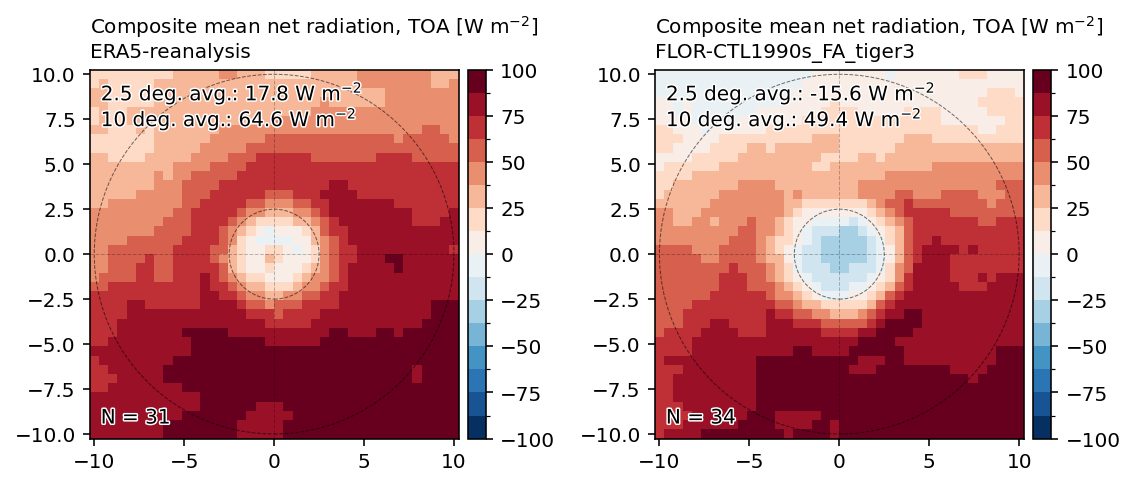

In [86]:
plot_composite(composite_TC_samples,
               configurations=None,
               get_difference=False,
               plotting_method='pcolormesh')

Domain center value over extent (-1, 1) for ERA5-reanalysis: 11.91.
Domain center value over extent (-1, 1) for FLOR-CTL1990s_FA_tiger3: -23.87.


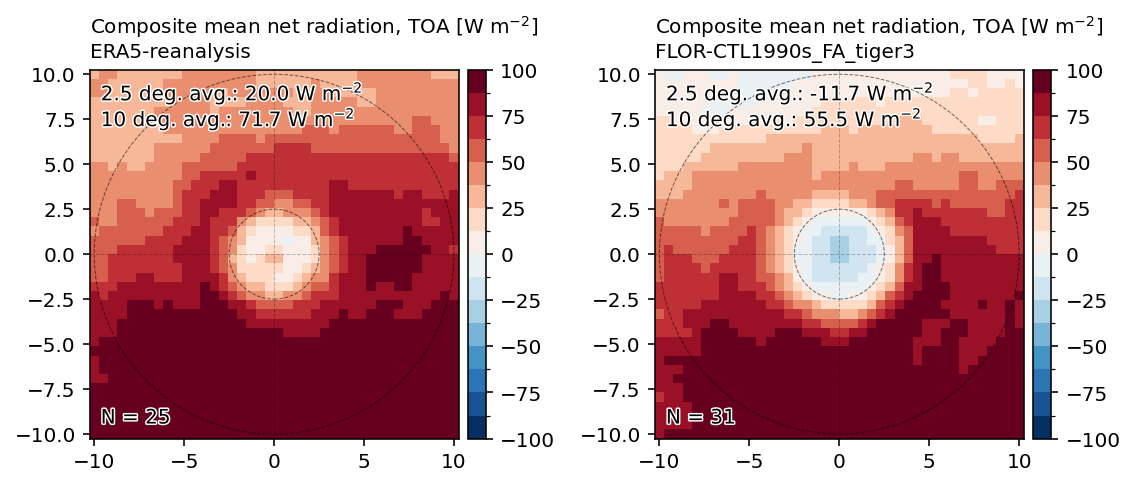

In [87]:
daytime_composite_TC_samples = hour_filter(composite_TC_samples, 21, 15)
plot_composite(daytime_composite_TC_samples,
               configurations=None,
               get_difference=False,
               plotting_method='pcolormesh')

---

#### Plot TC composite anomaly from climatology

In [63]:
importlib.reload(utilities)

intensity_parameter, intensity_range = 'min_slp', (0, 1000)
field_name = 'netrad_toa'
basin_name = 'global'

configurations = {'ERA5': {'experiment_name': 'reanalysis',
                           'year_range': (2001, 2020)},
                 'FLOR': {'experiment_name': 'CTL1990s_FA_tiger3',
                           'year_range': (1901, 1925)}}

compositing_mode = 'anomaly'

composite_TC_samples, composite_GCM_samples, composite_anomaly_samples = {}, {}, {}
for model_name in configurations.keys():
    experiment_name = configurations[model_name]['experiment_name']
    year_range = configurations[model_name]['year_range']
    print(f'Processing composites for {model_name}, {experiment_name} over years {year_range}...')
    composite_TC_sample, composite_GCM_sample = main(compositing_mode,
                                                     model_name,
                                                     experiment_name,
                                                     year_range,
                                                     field_name,
                                                     basin_name=basin_name,
                                                     intensity_parameter=intensity_parameter,
                                                     intensity_range=intensity_range,
                                                     parallel=True)
    composite_TC_samples[f'{model_name}-{experiment_name}'] = composite_TC_sample
    composite_GCM_samples[f'{model_name}-{experiment_name}'] = composite_GCM_sample
    composite_anomaly_samples[f'{model_name}-{experiment_name}-ANOM'] = composite_TC_sample - composite_GCM_sample

Processing composites for ERA5, reanalysis over years (2001, 2020)...
Composite sampling statistics for ERA5-reanalysis: N = 31; max. wind: 33.7 +/- 2.2
Processing composites for FLOR, CTL1990s_FA_tiger3 over years (1901, 1925)...
Composite sampling statistics for FLOR-CTL1990s_FA_tiger3: N = 34; max. wind: 37.5 +/- 2.5


Domain center value over extent (-1, 1) for ERA5-reanalysis-ANOM: -58.96.
Domain center value over extent (-1, 1) for FLOR-CTL1990s_FA_tiger3-ANOM: -102.45.


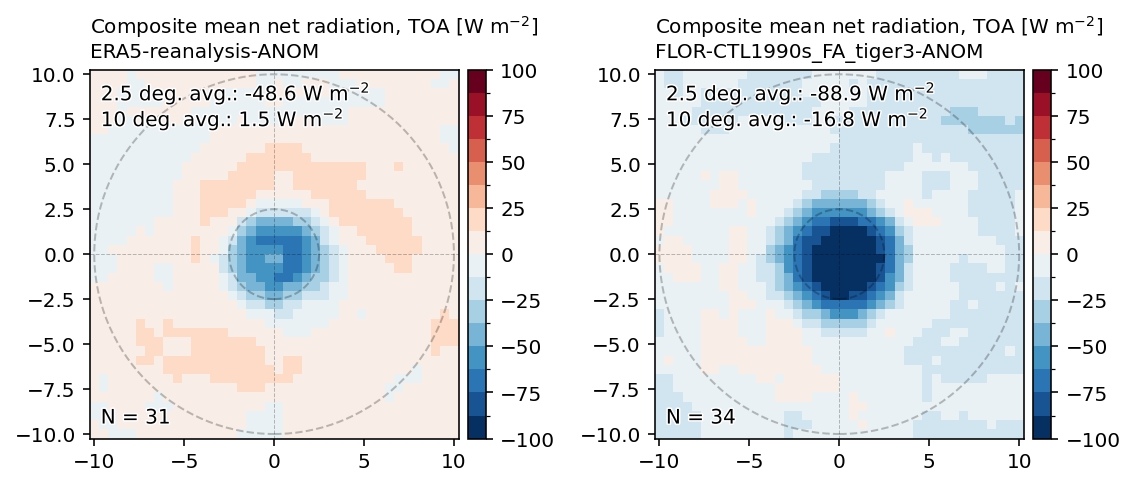

In [82]:
plot_composite(composite_anomaly_samples,
               configurations=None,
               get_difference=False,
               plotting_method='pcolormesh',
               dpi=144)

Domain center value over extent (-1, 1) for ERA5-reanalysis-ANOM: -32.65.
Domain center value over extent (-1, 1) for FLOR-CTL1990s_FA_tiger3-ANOM: -100.57.


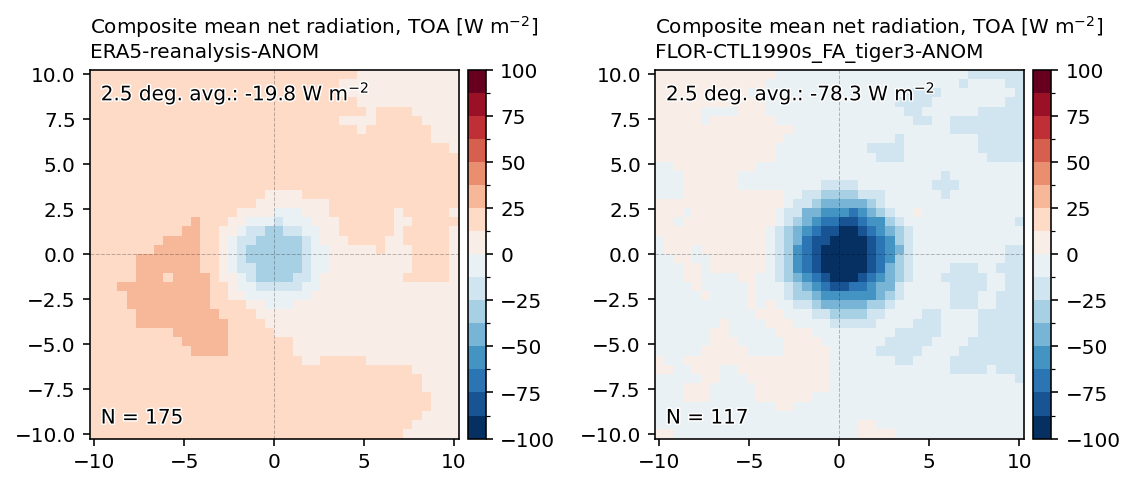

In [60]:
daytime_composite_anomaly_samples = hour_filter(composite_anomaly_samples, 21, 15)
plot_composite(daytime_composite_anomaly_samples,
               configurations=None,
               get_difference=False,
               plotting_method='pcolormesh',
               dpi=144)

#### Obtain hour (in TC local times) at which LMI sampling occurs

In [ ]:
sampling_hour_histogram(composite_anomaly_samples)